
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/analysis_mwl.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[analysis_mwl.ipynb](../_static/notebooks/analysis_mwl.ipynb) |
[analysis_mwl.py](../_static/notebooks/analysis_mwl.py)
</div>


# Joint modeling, fitting, and serialization


## Prerequisites

- Handling of Fermi-LAT data with gammapy [see the corresponding tutorial](fermi_lat.ipynb)
- Knowledge of spectral analysis to produce 1D On-Off datasets, [see the following tutorial](spectrum_analysis.ipynb)
- Using flux points to directly fit a model (without forward-folding)  [see the SED fitting tutorial](sed_fitting.ipynb)

## Context

Some science studies require to combine heterogeneous data from various instruments to extract physical informations. In particular, it is often useful to add flux measurements of a source at different energies to an analysis to better constrain the wide-band spectral parameters. This can be done using a joint fit of heterogeneous datasets.
 
**Objectives: Constrain the spectral parameters of the gamma-ray emission from the Crab nebula between 10 GeV and 100 TeV, using a 3D Fermi dataset, a H.E.S.S. reduced spectrum and HAWC flux points.**

## Proposed approach

This tutorial illustrates how to perfom a joint modeling and fitting of the Crab Nebula spectrum using different datasets.
The spectral parameters are optimized by combining a 3D analysis of Fermi-LAT data, a ON/OFF spectral analysis of HESS data, and flux points from HAWC.

In this tutorial we are going to use pre-made datasets. We prepared maps of the Crab region as seen by Fermi-LAT using the same event selection than the [3FHL catalog](https://arxiv.org/abs/1702.00664) (7 years of data with energy from 10 GeV to 2 TeV). For the HESS ON/OFF analysis we used two observations from the [first public data release](https://arxiv.org/abs/1810.04516) with a significant signal from energy of about 600 GeV to 10 TeV. These observations have an offset of 0.5° and a zenith angle of 45-48°. The HAWC flux points data are taken from a [recent analysis](https://arxiv.org/pdf/1905.12518.pdf) based on 2.5 years of data with energy between 300 Gev and 300 TeV. 

## The setup


In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit
from gammapy.modeling.models import Models
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from pathlib import Path

## Data and models files


The datasets serialization produce YAML files listing the datasets and models. In the following cells we show an example containning only the Fermi-LAT dataset and the Crab model. 

Fermi-LAT-3FHL_datasets.yaml:

In [2]:
!cat $GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml

datasets:
- name: Fermi-LAT
  type: MapDataset
  filename: Fermi-LAT-3FHL_data_Fermi-LAT.fits


We used as model a point source with a log-parabola spectrum. The initial parameters were taken from the latest Fermi-LAT catalog [4FGL](https://arxiv.org/abs/1902.10045), then we have re-optimized the spectral parameters for our dataset in the 10 GeV - 2 TeV energy range (fixing the source position).

Fermi-LAT-3FHL_models.yaml:

In [3]:
!cat $GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_models.yaml

components:
-   name: Crab Nebula
    type: SkyModel
    spectral:
        type: LogParabolaSpectralModel
        parameters:
        -   name: amplitude
            value: 0.018182745349064267
            unit: cm-2 s-1 TeV-1
            min: .nan
            max: .nan
            frozen: false
            error: 0.003026327991562108
        -   name: reference
            value: 5.054833602905273e-05
            unit: TeV
            min: .nan
            max: .nan
            frozen: true
            error: 0.0
        -   name: alpha
            value: 1.652368617859867
            unit: ''
            min: .nan
            max: .nan
            frozen: false
            error: 0.05762513693893088
        -   name: beta
            value: 0.03921700077803329
            unit: ''
            min: .nan
            max: .nan
            frozen: false
            error: 0.00521472221220211
    spatial:
        type: PointSpatialModel
        frame: icrs
        parameters:
        -   

## Reading  different datasets


### Fermi-LAT 3FHL: map dataset for 3D analysis
For now we let's use the datasets serialization only to read the 3D `MapDataset` associated to Fermi-LAT 3FHL data and models.

In [4]:
path = Path("$GAMMAPY_DATA/fermi-3fhl-crab")
filename = path / "Fermi-LAT-3FHL_datasets.yaml"

datasets = Datasets.read(filename=filename)

In [5]:
models = Models.read(path / "Fermi-LAT-3FHL_models.yaml")
print(models)

Models

Component 0: SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   1.82e-02  1 / (cm2 s TeV)
    reference    (frozen)   :   0.000  TeV         
    alpha                   :   1.652              
    beta                    :   0.039              
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.020  deg         

Component 1: FoVBackgroundModel

  Name                      : Fermi-LAT-bkg
  Datasets names            : ['Fermi-LAT']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.300              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




We get the Crab model in order to share it with the other datasets

In [6]:
print(models["Crab Nebula"])

SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   1.82e-02  1 / (cm2 s TeV)
    reference    (frozen)   :   0.000  TeV         
    alpha                   :   1.652              
    beta                    :   0.039              
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.020  deg         




### HESS-DL3: 1D ON/OFF dataset for spectral fitting

The ON/OFF datasets can be read from PHA files following the [OGIP standards](https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node5.html).
We read the PHA files from each observation, and compute a stacked dataset for simplicity.
Then the Crab spectral model previously defined is added to the dataset.

In [7]:
datasets_hess = Datasets()

for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets_hess.append(dataset)

dataset_hess = datasets_hess.stack_reduce(name="HESS")

datasets.append(dataset_hess)

In [8]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 




### HAWC: 1D dataset for flux point fitting

The HAWC flux point are taken from https://arxiv.org/pdf/1905.12518.pdf. Then these flux points are read from a pre-made FITS file and passed to a `FluxPointsDataset` together with the source spectral model.


In [9]:
# read flux points from https://arxiv.org/pdf/1905.12518.pdf
filename = "$GAMMAPY_DATA/hawc_crab/HAWC19_flux_points.fits"
flux_points_hawc = FluxPoints.read(filename)
dataset_hawc = FluxPointsDataset(data=flux_points_hawc, name="HAWC")

datasets.append(dataset_hawc)

In [10]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : 




## Datasets serialization

The `datasets` object contains each dataset previously defined. 
It can be saved on disk as datasets.yaml, models.yaml, and several data files specific to each dataset. Then the `datasets` can be rebuild later from these files.

In [11]:
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)

filename = path / "crab_10GeV_100TeV_datasets.yaml"

datasets.write(filename, overwrite=True)

HDU 'MASK_FIT' not found
/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
!cat crab-3datasets/crab_10GeV_100TeV_datasets.yaml

datasets:
- name: Fermi-LAT
  type: MapDataset
  filename: Fermi-LAT.fits
- name: HESS
  type: SpectrumDatasetOnOff
  filename: pha_obsHESS.fits
- name: HAWC
  type: FluxPointsDataset
  filename: HAWC.fits


In [13]:
datasets = Datasets.read(filename)
datasets.models = models

In [14]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : ['Crab Nebula', 'Fermi-LAT-bkg']

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : ['Crab Nebula']

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : ['Crab Nebula']




## Joint analysis

We run the fit on the `Datasets` object that include a dataset for each instrument


In [15]:
%%time
fit_joint = Fit(datasets)
results_joint = fit_joint.run()
print(results_joint)

HDU 'MASK_FIT' not found


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 305
	total stat : -12695.04

CPU times: user 3.82 s, sys: 4.29 ms, total: 3.82 s
Wall time: 3.82 s


Let's display only the parameters of the Crab spectral model

In [16]:
crab_spec = datasets[0].models["Crab Nebula"].spectral_model
print(crab_spec)

LogParabolaSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
amplitude 3.8966e-03 cm-2 s-1 TeV-1 nan nan  False 3.119e-04
reference 5.0548e-05            TeV nan nan   True 0.000e+00
    alpha 1.2560e+00                nan nan  False 1.747e-02
     beta 6.1986e-02                nan nan  False 9.778e-04


We can compute flux points for Fermi-LAT and HESS datasets in order plot them together with the HAWC flux point.

In [17]:
# compute Fermi-LAT and HESS flux points
energy_edges = MapAxis.from_energy_bounds("10 GeV", "2 TeV", nbin=5).edges

flux_points_fermi = FluxPointsEstimator(
    energy_edges=energy_edges, source="Crab Nebula"
).run([datasets["Fermi-LAT"]])


energy_edges = MapAxis.from_bounds(
    1, 15, nbin=6, interp="log", unit="TeV"
).edges
flux_points_hess = FluxPointsEstimator(
    energy_edges=energy_edges, source="Crab Nebula"
).run([datasets["HESS"]])

Now, Let's plot the Crab spectrum fitted and the flux points of each instrument.


(array([0.00698646, 0.02015874, 0.05816603, 0.16783227, 0.48426319]), array([0.01186753, 0.03424258, 0.09880353, 0.2850877 , 0.82259195]))
(array([0.25892541, 0.41036912, 0.65039123, 1.03080063, 1.6337089 ,
       2.58925412]), array([0.32596778, 0.51662412, 0.81879405, 1.29770111, 2.05671765,
       3.25967781]))
None


/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:415: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:416: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs

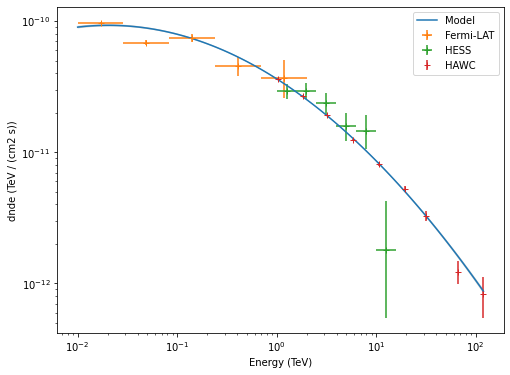

In [18]:
# display spectrum and flux points
energy_range = [0.01, 120] * u.TeV
plt.figure(figsize=(8, 6))
ax = crab_spec.plot(energy_range=energy_range, energy_power=2, label="Model")
crab_spec.plot_error(ax=ax, energy_range=energy_range, energy_power=2)
flux_points_fermi.plot(ax=ax, energy_power=2, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, energy_power=2, label="HESS")
flux_points_hawc.plot(ax=ax, energy_power=2, label="HAWC")
plt.legend();